<a href="https://colab.research.google.com/github/oscararagon/letschat/blob/master/Oscar/ANNDL_Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/POLIMI/SECONDO ANNO/ANNDL Lab/Challenge2022

/gdrive/My Drive/POLIMI/SECONDO ANNO/ANNDL Lab/Challenge2022


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


## Set seed for reproducibility


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## suppress warnings

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
#load dataset
!unzip training_data_final.zip

Archive:  training_data_final.zip
   creating: training_data_final/Species1/
  inflating: training_data_final/Species1/00000.jpg  
  inflating: training_data_final/Species1/00001.jpg  
  inflating: training_data_final/Species1/00002.jpg  
  inflating: training_data_final/Species1/00003.jpg  
  inflating: training_data_final/Species1/00004.jpg  
  inflating: training_data_final/Species1/00005.jpg  
  inflating: training_data_final/Species1/00006.jpg  
  inflating: training_data_final/Species1/00007.jpg  
  inflating: training_data_final/Species1/00008.jpg  
  inflating: training_data_final/Species1/00009.jpg  
  inflating: training_data_final/Species1/00010.jpg  
  inflating: training_data_final/Species1/00011.jpg  
  inflating: training_data_final/Species1/00012.jpg  
  inflating: training_data_final/Species1/00013.jpg  
  inflating: training_data_final/Species1/00014.jpg  
  inflating: training_data_final/Species1/00015.jpg  
  inflating: training_data_final/Species1/00016.jpg  
  inf

In [7]:
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Dataset split folders. Divide the dataset folder in train, validation and test
splitfolders.ratio('training_data_final', output="output", seed=1337, ratio=(0.8, 0.1,0.1))

Copying files: 3542 files [09:40,  6.10 files/s]


In [8]:
# Dataset folders
dataset_dir = 'output'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')  
test_dir = os.path.join(dataset_dir, 'test')

## Check the distribution of classes among training, validation and test sets

In [9]:
# Plot example images from dataset
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8' #7
]        

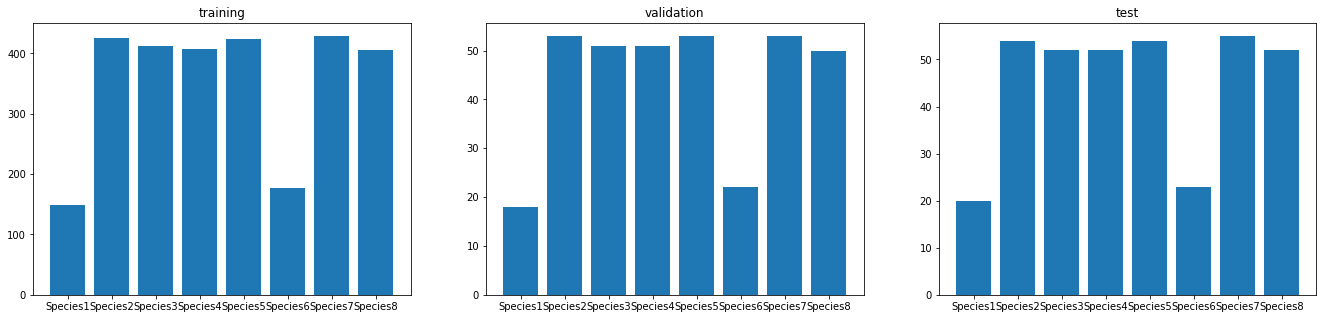

In [10]:
training_classes = [len(os.listdir(f'{training_dir}/{label}')) for label in labels]
validation_classes = [len(os.listdir(f'{validation_dir}/{label}')) for label in labels]
test_classes = [len(os.listdir(f'{test_dir}/{label}')) for label in labels]

fig = plt.figure(figsize=(23, 5))
plt.subplot(131)
plt.bar(labels, training_classes, )
plt.title("training")

plt.subplot(132)
plt.bar(labels, validation_classes)
plt.title("validation")

plt.subplot(133)
plt.bar(labels, test_classes)
plt.title("test")

plt.show()

the split result being stratified

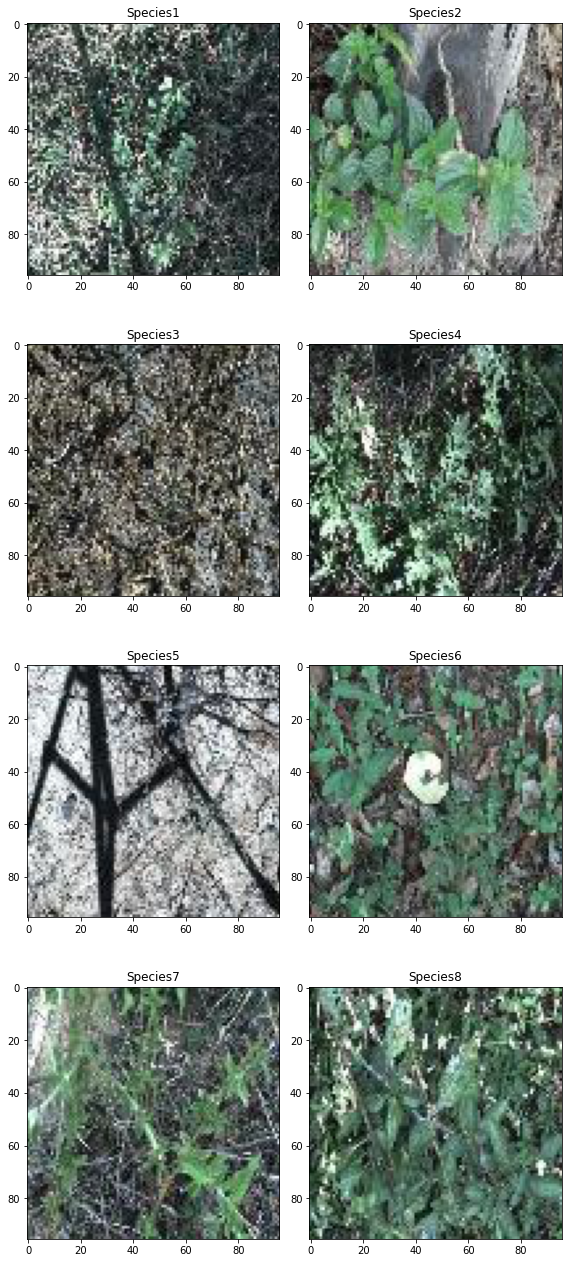

In [11]:
# Plot example images from dataset

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


## Load data using ImageDataGenerator

In [12]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale=1.0/255.0) # to normalize images
valid_data_gen = ImageDataGenerator(rescale=1.0/255.0)
test_data_gen = ImageDataGenerator(rescale=1.0/255.0)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [14]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(image)

  return batch  

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


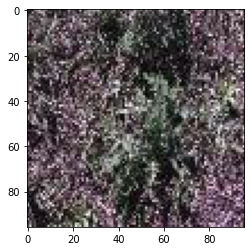

In [15]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

In [16]:
# models metadata
input_shape = (96, 96, 3)
epochs = 200

## Build the CNN model

In [17]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Utility functions to create callbacks and folders for training

In [18]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [19]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856 

In [22]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = train_gen,
    # batches?
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history



Epoch 1/200
354/354 [==============================] - 847s 2s/step - loss: 1.4330 - accuracy: 0.4528 - val_loss: 1.2458 - val_accuracy: 0.5157
Epoch 2/200
354/354 [==============================] - 96s 271ms/step - loss: 1.1789 - accuracy: 0.5553 - val_loss: 1.4382 - val_accuracy: 0.4872
Epoch 3/200
354/354 [==============================] - 99s 278ms/step - loss: 1.0422 - accuracy: 0.6006 - val_loss: 1.2552 - val_accuracy: 0.5328
Epoch 4/200
354/354 [==============================] - 97s 273ms/step - loss: 0.8978 - accuracy: 0.6642 - val_loss: 1.1331 - val_accuracy: 0.5698
Epoch 5/200
354/354 [==============================] - 99s 279ms/step - loss: 0.7297 - accuracy: 0.7197 - val_loss: 1.2868 - val_accuracy: 0.5869
Epoch 6/200
354/354 [==============================] - 98s 277ms/step - loss: 0.6013 - accuracy: 0.7808 - val_loss: 1.2287 - val_accuracy: 0.5954
Epoch 7/200
354/354 [==============================] - 99s 280ms/step - loss: 0.4068 - accuracy: 0.8565 - val_loss: 1.6342 - v

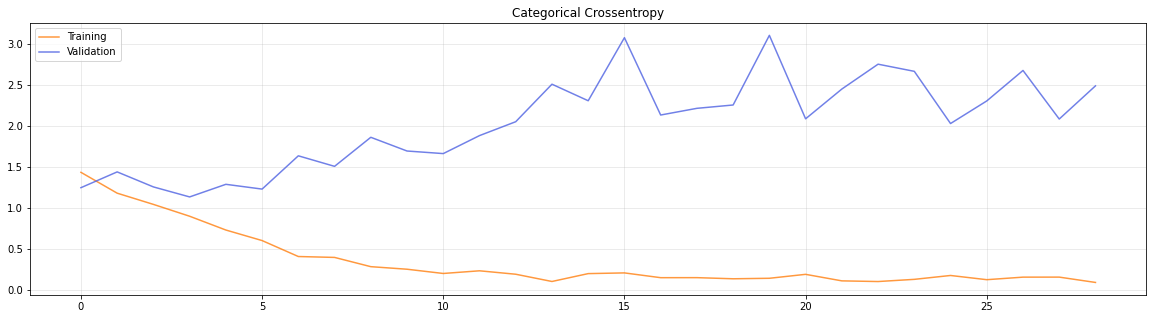

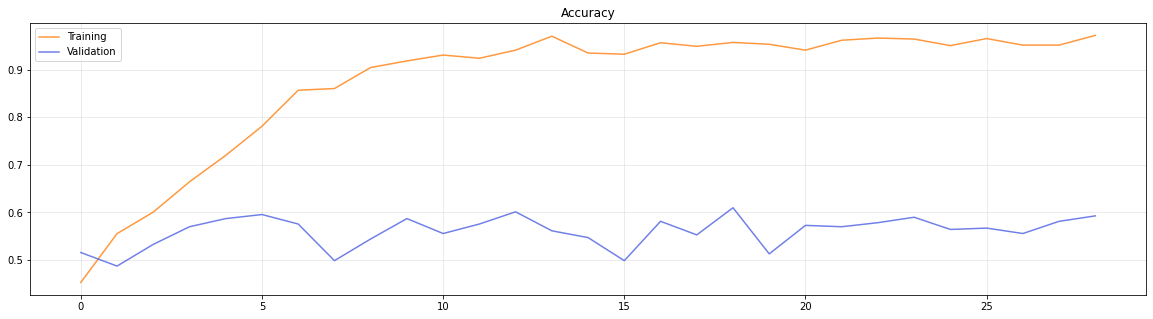

In [23]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save best epoch model
model.save("Homework1Models/CNN_no_augmentation_best")

In [20]:
model = tfk.models.load_model('Homework1Models/CNN_no_augmentation_best')

In [24]:
# Evaluate on test trainined with no data augmentation
model_test_metrics = model.evaluate(test_gen, return_dict=True)
print("Test metrics: ")
print(model_test_metrics)

46/46 [==============================] - 3s 73ms/step - loss: 2.2115 - accuracy: 0.5801
Test metrics: 
{'loss': 2.2114717960357666, 'accuracy': 0.580110490322113}


(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2
1/1 [==============================] - 0s 30ms/step


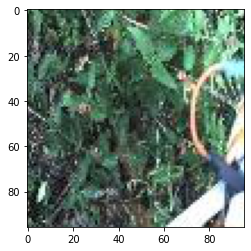

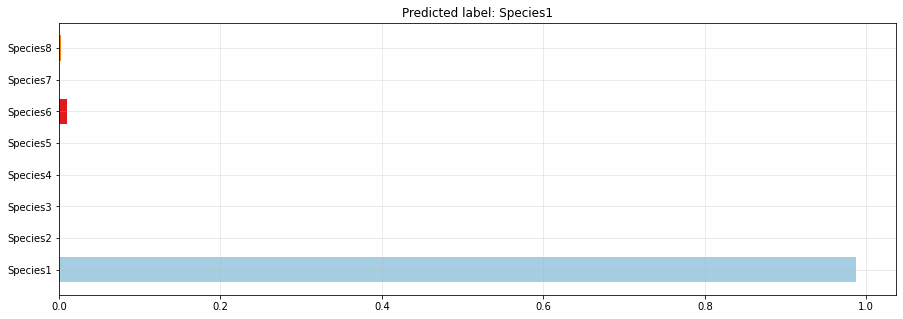

In [31]:
#predict example
X = get_next_batch(test_gen)[0]  

out = model.predict(tf.expand_dims(X[0], 0)) #first image of the batch


fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(15,5)
ax1.barh(list(labels), out[0], color=plt.get_cmap('Paired').colors)
ax1.set_title('Predicted label: '+labels[np.argmax(out)])
ax1.grid(alpha=.3)
plt.show()